<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fire-Feature-V.2" data-toc-modified-id="Fire-Feature-V.2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fire Feature V.2</a></span><ul class="toc-item"><li><span><a href="#Obtaining-Wind-Vectors" data-toc-modified-id="Obtaining-Wind-Vectors-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Obtaining Wind Vectors</a></span></li><li><span><a href="#Damping-Factor-Due-to-Wind-Direction" data-toc-modified-id="Damping-Factor-Due-to-Wind-Direction-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Damping Factor Due to Wind Direction</a></span></li><li><span><a href="#Calculate-the-arrival-time" data-toc-modified-id="Calculate-the-arrival-time-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calculate the arrival time</a></span></li><li><span><a href="#Split-fire-direction" data-toc-modified-id="Split-fire-direction-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Split fire direction</a></span></li></ul></li><li><span><a href="#Trainer-Object" data-toc-modified-id="Trainer-Object-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trainer Object</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Model</a></span><ul class="toc-item"><li><span><a href="#Train--PM2.5-with-Traffic" data-toc-modified-id="Train--PM2.5-with-Traffic-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train  PM2.5 with Traffic</a></span></li><li><span><a href="#log-PM2.5" data-toc-modified-id="log-PM2.5-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>log PM2.5</a></span></li><li><span><a href="#Grid-Search-PM2.5-feature" data-toc-modified-id="Grid-Search-PM2.5-feature-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Grid Search PM2.5 feature</a></span></li><li><span><a href="#Grid-Search-Fire-Zone" data-toc-modified-id="Grid-Search-Fire-Zone-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Grid Search Fire Zone</a></span></li><li><span><a href="#Train-PM10" data-toc-modified-id="Train-PM10-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Train PM10</a></span></li><li><span><a href="#Train-O3" data-toc-modified-id="Train-O3-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Train O3</a></span></li><li><span><a href="#Train-NO2" data-toc-modified-id="Train-NO2-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Train NO2</a></span></li><li><span><a href="#TPOP-PM10" data-toc-modified-id="TPOP-PM10-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>TPOP PM10</a></span></li></ul></li></ul></div>

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
from src.data.fire_data import cal_repeat_spots_ex_year, cal_repeat_spots

import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Fire Feature V.2

In [8]:
from bokeh.models import Arrow, NormalHead, VeeHead

In [33]:
# reinit the data and load saved process data 
dataset = Dataset('Bangkok')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (53424, 14)


In [9]:
dataset.city_info

{'Country': 'Thailand',
 'City': 'Bangkok',
 'City (ASCII)': 'Bangkok',
 'Region': 'Bangkok',
 'Region (ASCII)': 'Bangkok',
 'Population': '5104476',
 'Latitude': '13.754',
 'Longitude': '100.5014',
 'Time Zone': 'Asia/Bangkok',
 'lat_km': 1536.0,
 'long_km': 11188.0}

In [10]:
# obtain the city center in km
city_x = dataset.city_info['long_km'] 
city_y = dataset.city_info['lat_km'] 

print(city_x, city_y)
city_x = city_x*1E3
city_y = city_y*1E3

11188.0 1536.0


In [11]:
# pick a hotspot
row = dataset.fire.iloc[47]
spot_x = row['long_km']*1E3
spot_y = row['lat_km']*1E3

I need to conver the 2D hotspots data into a column data. In the earlier version, I assume that every hotspot travels to the city at an average wind speed. In a different part of the code, I also add a damping factor of (1/distance square) to lessen the contribution form hotspots, which are far away. This approach works alright for Chiang Mai, which has mostly calm wind property. But most cities are by the ocean with dynamic wind direction. In this version, I try to account for damping factor due to the wind direction. This is still challenging without detail historical wind map. Using the average wind direction of the city center of the same day. The satellite only takes data once a day so only the average value is needed. The damping factor is the calculated from the dot product between the hotspot vector and the wind direction vector. The figure below shows a hotspot vector for one hotspot.  

In [12]:
# set the size of the map 
stepx = 2E5
stepy = stepx


# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-stepx,city_x+1.2*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Hotspot Vector')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.scatter(city_x, city_y ,color='blue',line_color='black',size=10, legend_label='city_center')

p.scatter(spot_x ,spot_y ,color='red',line_color='black',size=10, legend_label='hotspot')


p.add_layout(Arrow(end=VeeHead(size=10), line_color="red",
                   x_start=spot_x, y_start=spot_y, x_end=city_x, y_end=city_y))

show(p)

## Obtaining Wind Vectors

I need to convert the string wind direction to a unit vector in Cartesian coordinates. This is done by using the compass definition.

In [177]:
# obtain the compass to degree conversion 
compass = pd.read_html('https://www.campbellsci.com/blog/convert-wind-directions')[0]
compass = compass.drop_duplicates('Compass Sectors')
# obtain the index
cardinal_var = compass['Values'].values

# convert to cartesian coordinate
# East is zero degree
degs = (cardinal_var - 1)*22.5 - 90
# add a unit vector 
wind_vec_x = [np.cos(np.radians(deg)).round(2) for deg in degs]
wind_vec_y = [np.sin(np.radians(deg)).round(2) for deg in degs]

compass['wind_vec_x'] = wind_vec_x
compass['wind_vec_y'] = wind_vec_y

# check if the direction is correct
# S means the wind is blowing from the south, so this is correct 
compass

,Values,Compass Sectors,wind_vec_x,wind_vec_y
0,1,N,0.00,-1.00
1,2,NNE,0.38,-0.92
2,3,NE,0.71,-0.71
3,4,ENE,0.92,-0.38
4,5,E,1.00,0.00
5,6,ESE,0.92,0.38
6,7,SE,0.71,0.71
7,8,SSE,0.38,0.92
8,9,S,0.00,1.00
9,10,SSW,-0.38,0.92


In [114]:
# create a dictionary that map wind direction to its vector 
wind_vec_x_dict = {}
wind_vec_y_dict = {}

for i, row in compass.iterrows():
    wind_vec_x_dict[row['Compass Sectors']] = row['wind_vec_x']
    wind_vec_y_dict[row['Compass Sectors']] = row['wind_vec_y']

print(wind_vec_x_dict)
print(wind_vec_y_dict)

{'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38, 'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
{'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71, 'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}


In [123]:
wind_vec_x_dict = {'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38, 'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
wind_vec_y_dict = {'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71, 'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}

In [154]:
# convert the wind direction to vector 
wea_proc = dataset.wea.copy()
# create a winvector columns
wea_proc['wind_vec_x'] =  wea_proc['Wind'].map(wind_vec_x_dict)
wea_proc['wind_vec_y'] =  wea_proc['Wind'].map(wind_vec_y_dict)
# rolling average smooth abrupt change
wea_proc = wea_proc.rolling(6, min_periods=1).mean()
# reample to daily average
wea_proc = wea_proc.resample('d').mean()

# normalize wind vector 
norm_vec = np.linalg.norm(wea_proc[['wind_vec_x', 'wind_vec_y']].values, axis=1)
wea_proc['wind_vec_x'] = wea_proc['wind_vec_x']/norm_vec
wea_proc['wind_vec_y'] = wea_proc['wind_vec_y']/norm_vec
wea_proc = wea_proc[['Wind_Speed(kmph)','wind_vec_x','wind_vec_y']]

## Damping Factor Due to Wind Direction

In [24]:
def add_wea_vec(wea_df:pd.DataFrame)-> pd.DataFrame:
    """Add wind direction vector columns. This is to prepare the weather data for fire feature engineering.
    
    
    Args:
        wea_df: weather dataframe with datetime index 'Wind' and 'Wind_Speed(kmph)' columns
        
    Returns: process weather dataframe
    

    """
    # dictionay to map the string direction 
    wind_vec_x_dict = {'N': 0.0, 'NNE': 0.38, 'NE': 0.71, 'ENE': 0.92, 'E': 1.0, 'ESE': 0.92, 'SE': 0.71, 'SSE': 0.38,
                       'S': 0.0, 'SSW': -0.38, 'SW': -0.71, 'WSW': -0.92, 'W': -1.0, 'WNW': -0.92, 'NW': -0.71, 'NNW': -0.38}
    wind_vec_y_dict = {'N': -1.0, 'NNE': -0.92, 'NE': -0.71, 'ENE': -0.38, 'E': 0.0, 'ESE': 0.38, 'SE': 0.71,
                       'SSE': 0.92, 'S': 1.0, 'SSW': 0.92, 'SW': 0.71, 'WSW': 0.38, 'W': 0.0, 'WNW': -0.38, 'NW': -0.71, 'NNW': -0.92}
    
    # keep only wind direction and wind speed columns
    wea_proc = wea_df[['Wind', 'Wind_Speed(kmph)']].copy()
    # create a winvector columns
    wea_proc['wind_vec_x'] =  wea_proc['Wind'].map(wind_vec_x_dict)
    wea_proc['wind_vec_y'] =  wea_proc['Wind'].map(wind_vec_y_dict)
    # rolling average smooth abrupt change. 
    wea_proc = wea_proc.rolling(6, min_periods=1).mean()
    # reample to daily average because the fire data is a daily data 
    wea_proc = wea_proc.resample('d').mean().round()
    # normalize wind vector 
    norm_vec = np.linalg.norm(wea_proc[['wind_vec_x', 'wind_vec_y']].values, axis=1)
    wea_proc['wind_vec_x'] = wea_proc['wind_vec_x']/norm_vec
    wea_proc['wind_vec_y'] = wea_proc['wind_vec_y']/norm_vec
    
    # drop the 'Wind' direction columns
    return wea_proc

In [43]:
def cal_wind_damp_row(row, city_x, city_y):
    """Calculate damping factor for each hotspot. This function should be applied to Panda DataFrame.
    
    Round to negative damping factor to zero.
    
    Args:
        row: panda row
        city_x: longitude in km in Mercator coordinate
        city_y: latitude in km in Mercator coordinate
        
    Return: float 
        a damping factor for that row.
        
    """
    # forming a vector in km unit 
    hot_vec = [(city_x - row['long_km']), (city_y - row['lat_km'])]
    # normalize this vector
    hot_vec = hot_vec/np.linalg.norm(hot_vec)
 
    wea_vec = [row['wind_vec_x'], row['wind_vec_y']]
     
    # round to zero and keep only the value greater than or equal to two
    return np.maximum(round(np.dot(hot_vec, wea_vec), 4), 0)

In [44]:
def cal_wind_damp(fire_df, wea_df, city_x, city_y):
    """Calculate the damping due to the wind direction. The new column is named 'winddamp' columns
    
    Args:
        fire_df: hotspots information
        wea_df: weather dataframe 
        city_x: longitude in km in Mercator coordinate
        city_y: latitude in km in Mercator coordinate
        
    Returns:   pd.DataFrame
    
    """
    fire_df['round_time'] = fire_df.index.round('D')
    # obtain process weather dataframe
    wea_proc = add_wea_vec(wea_df)
    # add windspeed and direction to the fire data
    fire_df = fire_df.merge(wea_proc, left_on='round_time', right_index=True, how='left')    
    # calculate the damping factors due to win direction
    fire_df['winddamp'] = fire_df.apply(cal_wind_damp_row, axis=1, args=(city_x, city_y))
    # keep only the columns with more than zero winddamp factor to reduce computation time
    fire_df = fire_df[fire_df['winddamp'] > 0]


    #remove unuse columns
    return fire_df.drop(['wind_vec_x', 'wind_vec_y', 'round_time'], axis=1)

In [45]:
# testing wind damping function
fire_df = dataset.fire.copy()
wea_df = dataset.wea
fire_col = 'power'
damp_surface = 'sphere'
# obtain the city center in km
city_x = dataset.city_info['long_km'] 
city_y = dataset.city_info['lat_km'] 

fire_df = cal_wind_damp(fire_df, wea_df, city_x, city_y)

## Calculate the arrival time 

The each hotspot also has different arrival time to the city. In the earlier version, I also use a single average value. Here, I include that option to use the wind speed in kmph and the distance from the city to calculate the arrival time to city.

`features.build_features.cal_power_damp()` calculate the arrival time for fire feature version 1 and version 2.


In [46]:
new_arrival_time = cal_arrival_time(detection_time=fire_df.index, distance=fire_df['distance'], wind_speed=fire_df['Wind_Speed(kmph)'])


Checking the process fire 

In [57]:
fire_df.tail(10)

,latitude,longitude,confidence,lat_km,long_km,distance,power,count,Wind_Speed(kmph,winddamp,arrival_time
datetime,,,,,,,,,,,
2020-08-21 10:55:00,4.293,100.764,67,475,11217,1061.396250,9.680,1,12.079861,0.1511,2020-08-25 03:00:00
2020-08-21 10:55:00,4.213,100.783,40,466,11219,1070.448971,10.527,1,12.079861,0.1527,2020-08-25 04:00:00
2020-08-21 10:55:00,4.094,100.894,82,453,11231,1083.853311,26.257,1,12.079861,0.1633,2020-08-25 05:00:00
2020-08-21 10:55:00,3.742,101.524,34,414,11302,1127.776574,11.484,1,12.079861,0.2237,2020-08-25 08:00:00
2020-08-21 10:55:00,3.690,101.522,40,408,11301,1133.645888,12.540,1,12.079861,0.2223,2020-08-25 09:00:00
2020-08-21 10:55:00,6.481,100.420,62,718,11179,818.049510,8.900,1,12.079861,0.1131,2020-08-24 07:00:00
2020-08-22 09:55:00,20.111,110.430,50,2272,12293,1327.675036,38.844,1,13.652778,0.2937,2020-08-26 11:00:00
2020-08-22 10:00:00,13.300,108.936,12,1484,12127,940.438727,38.779,1,13.652778,0.8081,2020-08-25 07:00:00
2020-08-22 22:25:00,7.206,103.801,100,799,11555,823.321322,15.600,1,9.288194,0.9877,2020-08-26 15:00:00


The windamp factor depends on the latitude and longitude of the spot and the wind direction, and the arrival_time varies depending on the current wind speed.

The process data also throw aways half of the hotspots whose vector to the city is opposite to the wind vector.

In [55]:
print('orginal fire shape', dataset.fire.shape)
print('processed fire shape', fire_df.shape)

orginal fire shape (3569659, 8)
processed fire shape (1331837, 11)


There is also an error due to that collection time of the satellite, and additional adjustment of the arrival time maybe required. Also, I also had to add the damping factor due to the distance and sum all the hotspots for an hour window. These parameters still have to be optimized during the training (`src.models.train_model.sk_op_fire()`). I already accounted for in fire feature v1. At the end, the fire feature engineering code `dataset.merge_fire()` inside dataset object look like this.

In [ ]:
    def merge_fire(self, fire_dict=None, damp_surface='sphere', wind_damp=False):
        """Process raw hotspot data into fire feature and merge with the rest of the data.
        
        If wind_damp is True, use self.damped_fire attribute for fire data, if False, use self.fire attribute.  
        
        Call src.features.build_features.get_fire_feature() to calcuate the daming due to distance and shift due to effective wind_speed. 
        
        The fire_proc dataframe is merged with the rest of the pollution, and weather dataframe. 
        
        Args:
            fire_dict(optional): fire dictionary containing wind_speed, shift and roll as keys [default:None] 
            damp_surface(optional): damping surface, either 'sphere', or 'cicle' 
            wind_damp(optional): if True, use fire_damp attribute for fire feature calculation instead of fire. If fire_damp hasn't exsited, calculate it. 
        
        Returns: (list, list)
            fire_cols: list of the fire columns
            zone_list: a list of fire zone 
        
        """
        if wind_damp:
            # use wind_damp fire default option
            # set self.fire_dict attribute 
            if fire_dict is None:
                print('use default fire feature')
                fire_dict = {'w_speed': 1, 'shift': -5, 'roll': 44}
                self.fire_dict = fire_dict

            # check if has damped_fire attribute
            if not hasattr(self, 'damped_fire'):
                #create the damped fire first 
                self.get_wind_damp_fire()
            # use damped fire attribute      
            fire_df = self.damped_fire
              
        else:

            # set self.fire_dict attribute
            if fire_dict is None:
                print('use default fire feature')
                fire_dict = {'w_speed': 7, 'shift': -5, 'roll': 44}
                self.fire_dict = fire_dict
            # use raw fire data        
            fire_df = self.fire

        # obtain processed fire dataframe and the fire columns     
        fire_proc, fire_cols = get_fire_feature(fire_df, zone_list=self.zone_list,
                                                fire_col='power', damp_surface=damp_surface,
                                                shift=fire_dict['shift'], roll=fire_dict['roll'], w_speed=fire_dict['w_speed'])

        # merge with fire data
        data = self.data_no_fire.merge(
            fire_proc,
            left_index=True,
            right_index=True,
            how='inner')
        data = data.dropna()
        data = data.loc[~data.index.duplicated(keep='first')]
        self.data = data
        return fire_cols, self.zone_list

I still wanna be able to switch between v1 and v2 of the fire feature; therefore wind_damp parameter specified this option.  `wind_damp==True` means using fire_feature v2.

This function has to be call often under `sk_op_fire()` function, but the `dataset.damp_fire` is always the same and therefore only have to be called once by calling `dataset.get_wind_damp_fire()` function. Let's test this function.

In [17]:
# check the fire columns
dataset.fire.tail(10)

,latitude,longitude,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,,,
2020-08-21 10:55:00,4.094,100.894,82,453,11231,1083.853311,26.257,1
2020-08-21 10:55:00,3.742,101.524,34,414,11302,1127.776574,11.484,1
2020-08-21 10:55:00,3.690,101.522,40,408,11301,1133.645888,12.540,1
2020-08-21 10:55:00,6.481,100.420,62,718,11179,818.049510,8.900,1
2020-08-22 09:55:00,20.111,110.430,50,2272,12293,1327.675036,38.844,1
2020-08-22 10:00:00,13.300,108.936,12,1484,12127,940.438727,38.779,1
2020-08-22 11:35:00,22.246,95.703,38,2525,10654,1123.955960,27.888,1
2020-08-22 11:35:00,22.288,95.691,29,2530,10652,1129.305982,24.696,1
2020-08-22 22:25:00,7.206,103.801,100,799,11555,823.321322,15.600,1


In [26]:
%%time
dataset.get_wind_damp_fire()

Wall time: 5min 5s


In [18]:
dataset.damped_fire.tail()

,latitude,longitude,confidence,lat_km,long_km,distance,power,count,Wind_Speed(kmph,winddamp
2020-08-25 09:00:00,3.690,101.522,40,408,11301,1133.645888,12.540,1,12.0,0.0997
2020-08-26 09:00:00,20.111,110.430,50,2272,12293,1327.675036,38.844,1,14.0,0.1965
2020-08-25 05:00:00,13.300,108.936,12,1484,12127,940.438727,38.779,1,14.0,0.7451
2020-08-26 18:00:00,7.206,103.801,100,799,11555,823.321322,15.600,1,9.0,0.8952
2020-08-26 18:00:00,7.207,103.810,82,799,11556,823.767564,8.100,1,9.0,0.8947


The last two hotspots arrive at Bangkok three days later.  

Next, I test the different between two versions of fire feature functions.

In [21]:
%%time
# version 1
dataset.merge_fire(fire_dict=None, damp_surface='sphere', wind_damp=False, wind_lag=False)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

use default fire feature
(52909, 20)
Wall time: 11.2 s


,PM2.5,Temperature(C),Humidity(%),Wind_Speed(kmph,wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day,fire_0_100,fire_100_200,fire_200_400,fire_400_600,fire_600_800,fire_800_1000
datetime,,,,,,,,,,,,,,,,,,,,
2020-08-27 20:00:00,12.6,31.0,62.0,11.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-27 21:00:00,12.7,29.0,74.0,16.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-27 22:00:00,12.9,28.0,79.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-27 23:00:00,13.1,28.0,79.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-28 00:00:00,13.1,28.0,79.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
%%time
try:
    del dataset.damped_fire
except:
    pass

# version 2
dataset.merge_fire( fire_dict=None, damp_surface='sphere', wind_damp=True, wind_lag=True)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

data no fire has shape (53424, 14)
use default fire feature
obtain damp_fire attribute
cal_wind_lag
(53424, 20)
Wall time: 5min 32s


,PM2.5,Temperature(C),Humidity(%),Wind_Speed(kmph,wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day,fire_0_100,fire_100_200,fire_200_400,fire_400_600,fire_600_800,fire_800_1000
datetime,,,,,,,,,,,,,,,,,,,,
2020-09-16 19:00:00,12.3,31.0,66.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,19.0,0.0,0.0,0.0,0.0,0.001478,0.074771
2020-09-16 20:00:00,12.2,30.0,70.0,16.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,20.0,0.0,0.0,0.0,0.0,0.001478,0.074771
2020-09-16 21:00:00,12.3,29.0,79.0,14.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,21.0,0.0,0.0,0.0,0.0,0.001478,0.074771
2020-09-16 22:00:00,12.3,30.0,79.0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,22.0,0.0,0.0,0.0,0.0,0.001478,0.074771
2020-09-16 23:00:00,12.3,29.0,79.0,13.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,23.0,0.0,0.0,0.0,0.0,0.001478,0.074771


In [44]:
dataset.damped_fire.tail()

,latitude,longitude,confidence,lat_km,long_km,distance,power,count,Wind_Speed(kmph,winddamp
2020-08-25 05:00:00,13.300,108.936,12,1484,12127,940.438727,38.779,1,14.0,0.7451
2020-08-25 20:00:00,22.246,95.703,38,2525,10654,1123.955960,27.888,1,14.0,0.0000
2020-08-25 20:00:00,22.288,95.691,29,2530,10652,1129.305982,24.696,1,14.0,0.0000
2020-08-26 18:00:00,7.206,103.801,100,799,11555,823.321322,15.600,1,9.0,0.8952
2020-08-26 18:00:00,7.207,103.810,82,799,11556,823.767564,8.100,1,9.0,0.8947


The last data is different for fire features v1, and v2 because of different arrival time.


There are four options for fire feature by setting wind_damp and wind_lag to be True or False separately. The default (Fire V1) is both False. These four options will be tested during the training and pick the one with the lowest error. To change fire feature option, one must delete the old damp_fire attribute.

In [47]:
%%time

try:
    del dataset.damped_fire
except:
    pass

# version 2
dataset.merge_fire( fire_dict=None, damp_surface='sphere', wind_damp=False, wind_lag=True)
# check the dataset after merging
print(dataset.data.shape)
dataset.data.tail()

use default fire feature
obtaining damped_fire attribute
cal_wind_lag
(53424, 20)
Wall time: 5min 59s


,PM2.5,Temperature(C),Humidity(%),Wind_Speed(kmph,wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day,fire_0_100,fire_100_200,fire_200_400,fire_400_600,fire_600_800,fire_800_1000
datetime,,,,,,,,,,,,,,,,,,,,
2020-09-16 19:00:00,12.3,31.0,66.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,19.0,0.0,0.0,0.0,0.0,0.019116,0.175389
2020-09-16 20:00:00,12.2,30.0,70.0,16.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,20.0,0.0,0.0,0.0,0.0,0.017893,0.175389
2020-09-16 21:00:00,12.3,29.0,79.0,14.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,21.0,0.0,0.0,0.0,0.0,0.017893,0.177269
2020-09-16 22:00:00,12.3,30.0,79.0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,22.0,0.0,0.0,0.0,0.0,0.017893,0.178305
2020-09-16 23:00:00,12.3,29.0,79.0,13.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,23.0,0.0,0.0,0.0,0.0,0.013392,0.179366


## Split fire direction

During the fire build, the direction of a hotspot is stored under ['spot_direct'] columns. This columns tell. The cardinal direction (N, E, W, S).  

In [178]:
fire = dataset.fire.loc['2018-12-01':'2019-01-01']
colors = get_color(color_length=4)
fire.head()
city_x = dataset.city_info['long_km']
city_y = dataset.city_info['lat_km']


stepx = 1E6
stepy = stepx
x = city_x*1000
y = city_y*1000

# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.5*stepx,x +0.5*stepx), y_range=(y-stepy*0.1, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
#p.scatter(x, y,color='blue',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season
for direction, color in zip(fire['spot_direct'].unique(), colors):

    temp = fire[fire['spot_direct'] == direction]
    p.scatter(temp['long_km']*1000,temp['lat_km']*1000,color=color,size=3, alpha=1,legend_label= 'fire_' + direction)


show(p)

if split_direct ==True, the fire in each zone is split further into the direction.

In [183]:
dataset.merge_fire(split_direct=True)
dataset.data.head()

use default fire feature


,PM2.5,Temperature(C),Humidity(%),Wind_Speed(kmph),wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain,...,fire_400_600_N,fire_400_600_W,fire_600_800_S,fire_600_800_E,fire_600_800_N,fire_600_800_W,fire_800_1200_E,fire_800_1200_N,fire_800_1200_S,fire_800_1200_W
datetime,,,,,,,,,,,,,,,,,,,,,
2014-08-15 00:00:00,3.0,25.0,89.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-7.430081e-14,-4.093947e-16,2.740863e-16,0.035629,-5.867806e-13,4.462576e-15,0.663259,1.687817e-03,0.013893,1.452744e-14
2014-08-15 01:00:00,3.0,25.0,89.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-7.430081e-14,-4.093947e-16,2.740863e-16,0.034558,-5.867806e-13,4.462576e-15,1.131435,1.687817e-03,0.013893,1.452744e-14
2014-08-15 02:00:00,3.3,25.0,89.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-7.430081e-14,-4.093947e-16,2.740863e-16,0.034558,-5.867806e-13,4.462576e-15,1.206208,1.687817e-03,0.013893,1.452744e-14
2014-08-15 03:00:00,2.8,25.0,89.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-7.430081e-14,-4.093947e-16,2.740863e-16,0.034558,-5.867806e-13,4.462576e-15,1.206208,1.687817e-03,0.013893,1.452744e-14
2014-08-15 04:00:00,2.8,24.0,94.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-7.430081e-14,-4.093947e-16,2.740863e-16,0.036856,-5.867806e-13,4.462576e-15,1.206208,-1.350395e-14,0.013893,1.452744e-14


# Trainer Object

Model Optimization breakdown into many steps.  I have a Trainer object with functions for each optimization step. This allows easy experiments with parameters, and can start an optimization mid-step without having to re-do the earlier steps again. This section illustrate how each function is used. At the end,  the entire optimization steps are carried out in a single function `train_model.train_city()`. This functions call a bunch of functions in train_model.py. Many of those functions are optimization using 
scikit-optimize library. 

1. `trainer.op_rf()` finds a reasonable parameters RandomForestRegressor model. Build a model input data using default fire parameters. Split the data into train, validation, and test set. Using the training and validation sets. 
1. `trainer.op2_rm_cols()` removes lower importance features from the model input. This is done by try to drop the data and see if the error decrease. 
1. `trainer.op_fire()` optimizes for the best fire features. Assuming that the pollution from a hotspot travels to the city at a certain average speed and linger in the environment for an unknown duration. This optimization step finds out the average travel speed and average linger duration.
1. `trainer.op_fire_zone()` experiment with various distance of the outer fire zones. Keep that give the best model performance.
1. `trainer.op4_lag()` improves model performance by adding lag columns (of weather and fire). The effects of weather and hotspots can have a time lag effect. This step search for the amount of lagged to add to the model, and remove lower importance lag columns. The earlier step often adds too many lagged columns. I prune these columns here. 
1. `trainer.op_rf()` optimize for RandomForestRegressor parameters again
1. Merge training and validation set and fit the model.  
1. Save model and model meta information. The Model meta would contain fire feature parameters, the lagged values, and columns to use.

After obtaining reasonable hyperparameters, I use `src.train_model.train_city_s1()` function to call all the optimization step. This function act as a master that control the `trainer` object.
 

Note that I did experiments with other machine learning model and neural network. I still find that the RandomForestRegressor has the best performance.

In [6]:
# initialize a trainer object
trainer = Trainer(city='Bangkok', pollutant='PM2.5')

data no fire has shape (53419, 21)


In [10]:
#op1
trainer.op_rf()

use default fire feature
{'n_estimators': 60, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.2627580452587204
val score after op_rf {'val_r2_score': 0.3226478760731051, 'val_mean_squared_error': 138.02381126825222, 'val_mean_absolute_error': 8.796036212666762}
test score after op_rf {'test_r2_score': 0.35212467064406705, 'test_mean_squared_error': 124.38347898709476, 'test_mean_absolute_error': 8.383897833919228}


In [21]:
#op2
trainer.op2_rm_cols()

old cols length 23
drop wind_E
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_600', 'fire_600_800', 'fire_800_1000']
score after dropping columns {'r2_score': 0.3368995504886686, 'mean_squared_error': 135.1197524334081, 'mean_absolute_error': 8.752155888651068}


# Train Model

##  Train  PM2.5 with Traffic

=================find the best RF model=================
best rf score  0.38024281879436866
val score after op_rf {'val_r2_score': 0.6168, 'val_mean_squared_error': 76.6597, 'val_mean_absolute_error': 6.7447, 'val_r2': 0.7332}


  0%|                                                                                                                                | 0/23 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:11<00:00,  3.12s/it]


score after dropping columns  {'r2_score': 0.6253, 'mean_squared_error': 74.9562, 'mean_absolute_error': 6.6223, 'r2': 0.7407}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 17.48, 'shift': -7, 'roll': 134, 'damp_surface': 1.89, 'wind_damp': False, 'wind_lag': False, 'split_direct': 0} is still better than optimized score =74.48822780604972
======== trim fire zone_list ========
final zone list [0, 100, 200, 400, 600, 800, 1100] give score {'val_r2_score': 0.6319, 'val_mean_squared_error': 73.6497, 'val_mean_absolute_error': 6.5401, 'val_r2': 0.7454}
old score 73.6497, new score 77.2423
keep old cat hour option, which is False
val score after cat_hour(){'val_r2_score': 0.6062, 'val_mean_squared_error': 78.762, 'val_mean_absolute_error': 6.7765, 'val_r2': 0.7249}
old score 78.762, new score 79.9768
keep old cat month option, which is 1
val score after cat_month()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [31:30<00:00,  9.00s/it]


score after dropping columns  {'r2_score': 0.6537, 'mean_squared_error': 69.2732, 'mean_absolute_error': 6.3556, 'r2': 0.7601}
best rf score  0.37982701784025485
val score after op6 {'val_r2_score': 0.6164, 'val_mean_squared_error': 76.7287, 'val_mean_absolute_error': 6.6375, 'val_r2': 0.7315}
test score after op6  {'testop6_r2_score': 0.4727, 'testop6_mean_squared_error': 78.2838, 'testop6_mean_absolute_error': 6.7042, 'testop6_r2': 0.752}
final score for test set {'test_r2_score': 0.6263, 'test_mean_squared_error': 74.2869, 'test_mean_absolute_error': 6.6518, 'test_r2': 0.775}
daily avg score for test set {'avg_trn_r2_score': 0.5523, 'avg_trn_mean_squared_error': 65.6774, 'avg_trn_mean_absolute_error': 6.1597, 'avg_trn_r2': 0.7818}
Wall time: 4h 49min


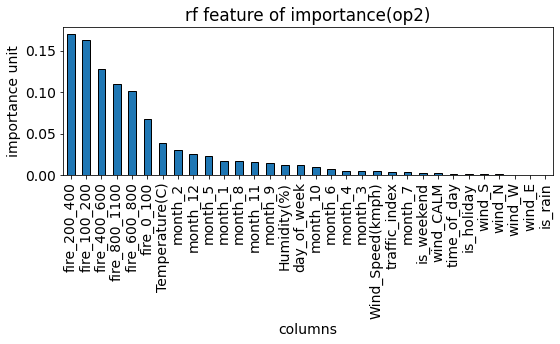

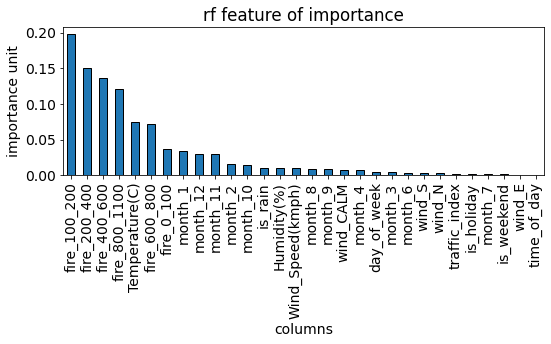

In [46]:
%%time
# training 48 hour avg center
dataset, model, trainer = train_city_s1(city='Bangkok', pollutant= 'PM2.5', op_fire_twice=False, search_wind_damp=True, choose_cat_hour=True, choose_cat_month=True)

In [47]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM2.5')

raw model performance {'test_r2_score': 0.6285, 'test_mean_squared_error': 73.8316, 'test_mean_absolute_error': 6.6281, 'test_r2': nan}
daily avg training error {'avg_trn_r2_score': 0.7784, 'avg_trn_mean_squared_error': 38.7238, 'avg_trn_mean_absolute_error': 4.6275, 'avg_trn_r2': 0.8864}
daily avg test error {'avg_test_r2_score': 0.553, 'avg_test_mean_squared_error': 65.4323, 'avg_test_mean_absolute_error': 6.1461, 'avg_test_r2': 0.7831}


In [ ]:
%%time
# training 48 hour avg center
# Narrow stations
dataset, model, trainer = train_city_s1(city='Bangkok', pollutant= 'PM2.5', op_fire_twice=False, search_wind_damp=True, choose_cat_hour=True, choose_cat_month=False)

=================find the best RF model=================
best rf score  0.18605378613765017
val score after op_rf {'val_r2_score': 0.5254, 'val_mean_squared_error': 103.7587, 'val_mean_absolute_error': 8.5068, 'val_r2': nan}
================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:51<00:00, 10.11s/it]


score after dropping columns  {'r2_score': 0.5271, 'mean_squared_error': 103.3833, 'mean_absolute_error': 8.4662, 'r2': 0.7426}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 19.74, 'shift': -40, 'roll': 24, 'damp_surface': 3.89, 'wind_damp': False, 'wind_lag': False, 'split_direct': 0} is still better than optimized score =95.89008424572833
======== trim fire zone_list ========
final zone list [0, 100, 200, 400, 600, 800, 900] give score {'val_r2_score': 0.5611, 'val_mean_squared_error': 95.9541, 'val_mean_absolute_error': 8.0686, 'val_r2': 0.7365}
old score 95.9541, new score 96.2403
keep old cat hour option, which is False
val score after cat_hour(){'val_r2_score': 0.5586, 'val_mean_squared_error': 95.6933, 'val_mean_absolute_error': 8.0698, 'val_r2': 0.7346}
===== improve model performance by adding lag columns =====


In [ ]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM2.5')

In [ ]:
%%time
# training 48 hour avg center
# Narrow stations
dataset, model, trainer = train_city_s1(city='Bangkok', pollutant= 'PM2.5', op_fire_twice=False, search_wind_damp=True, choose_cat_hour=True, choose_cat_month=False)

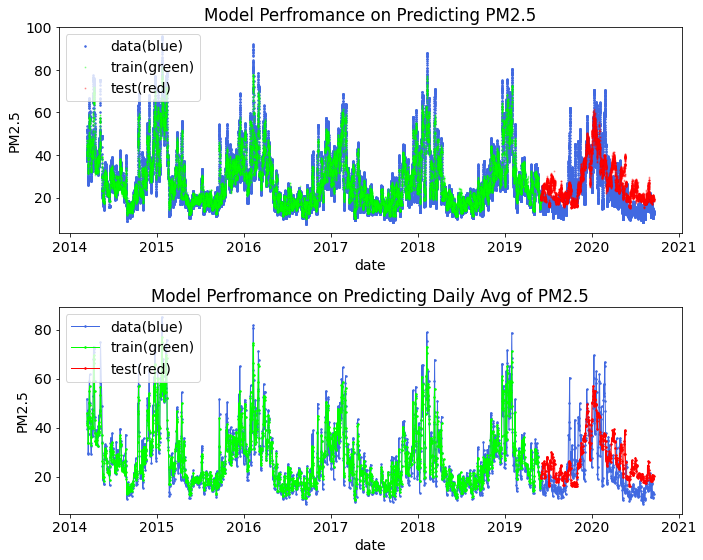

In [69]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.8, 0.2], xlim=[], to_save=True)

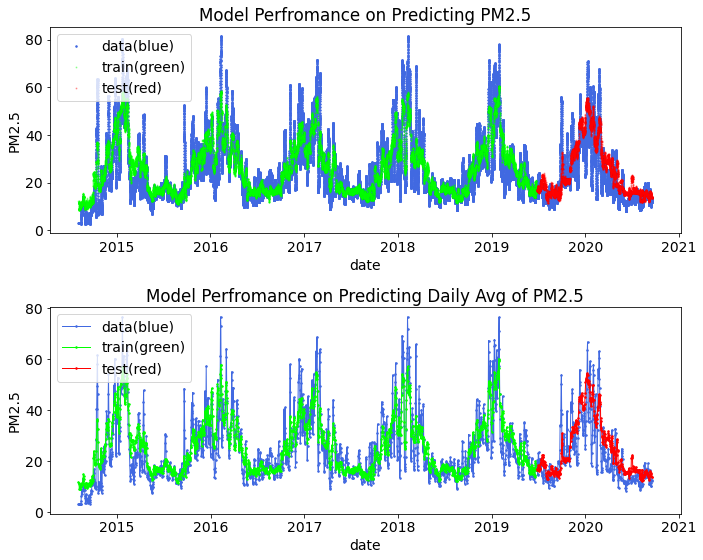

In [48]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.8, 0.2], xlim=[], to_save=True)

## Grid Search PM2.5 feature

I have a function to search all possible combination of feature parameters and records the scores. However, it turns out that the default setting is the best.

In [ ]:
%%time
result_df = train_hyper_search(city= 'Bangkok', pollutant='PM2.5')




  0%|                                                                                                                                 | 0/2 [00:00<?, ?it/s]

found exisiting search file
explored parameter [(0, 0, 1), (0, 1, 1), (1, 0, 1), (0, 0, 0), (0, 1, 0), (1, 0, 0)]
parameter (1, 1, 0)
before dropping traffic (53274, 15)
after dropping traffic (53274, 14)
=================find the best RF model=================
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
best rf score  0.29199869661561684
val score after op_rf {'val_r2_score': 0.5015858679124905, 'val_mean_squared_error': 138.81547898801327, 'val_mean_absolute_error': 9.087031598255786}
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_





  0%|                                                                                                                               | 0/228 [00:00<?, ?it/s]

val score after cat_hour(){'val_r2_score': 0.4933277358763324, 'val_mean_squared_error': 140.94291026338038, 'val_mean_absolute_error': 9.147751338498201}
================ remove unncessary columns no lag=================






  0%|▌                                                                                                                    | 1/228 [00:21<1:23:03, 21.95s/it]



  1%|█                                                                                                                    | 2/228 [00:44<1:22:56, 22.02s/it]



  1%|█▌                                                                                                                   | 3/228 [01:06<1:22:26, 21.98s/it]



  2%|██                                                                                                                   | 4/228 [01:27<1:21:56, 21.95s/it]



  2%|██▌                                                                                                                  | 5/228 [01:49<1:21:33, 21.94s/it]



  3%|███                                                                                                                  | 6/228 [02:11<1:21:14, 21.96s/it]



  3%|███▌                           

 42%|█████████████████████████████████████████████████▏                                                                    | 95/228 [34:53<48:54, 22.07s/it]



 42%|█████████████████████████████████████████████████▋                                                                    | 96/228 [35:15<48:29, 22.04s/it]



 43%|██████████████████████████████████████████████████▏                                                                   | 97/228 [35:37<48:12, 22.08s/it]



 43%|██████████████████████████████████████████████████▋                                                                   | 98/228 [35:59<47:49, 22.07s/it]



 43%|███████████████████████████████████████████████████▏                                                                  | 99/228 [36:21<47:22, 22.04s/it]



 44%|███████████████████████████████████████████████████▎                                                                 | 100/228 [36:43<47:01, 22.04s/it]



 44%|███████████████████████████████████

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 189/228 [1:09:24<14:21, 22.08s/it]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 190/228 [1:09:46<14:00, 22.12s/it]



 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 191/228 [1:10:09<13:38, 22.13s/it]



 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 192/228 [1:10:30<13:13, 22.05s/it]



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 193/228 [1:10:52<12:48, 21.97s/it]



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 194/228 [1:11:14<12:27, 22.00s/it]



 86%|███████████████████████████████████

score after dropping columns  {'r2_score': 0.5086233336053435, 'mean_squared_error': 136.68807689121343, 'mean_absolute_error': 9.074407385728406}
================= find the best fire feature ===================
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
optimizing fire parameter using skopt optimizer. This will take about 4 hours
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_

fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
f

fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fir

fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_

fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_100_200_E
fire_100_200_N
fire_100_200_S
fire_100_200_W
fire_200_400_E
fire_200_400_N
fire_200_400_S
fire_200_400_W
fire_400_600_E
fire_400_600_N
fire_400_600_S
fire_400_600_W
fire_600_800_E
fire_600_800_N
fire_600_800_S
fire_600_800_W
fire_800_1150_E
fire_800_1150_N
fire_800_1150_S
fire_800_1150_W
fire_0_100_E
fire_0_100_N
fire_0_100_S
fire_0_100_W
fire_10





  0%|                                                                                                                              | 0/4769 [00:00<?, ?it/s]



  0%|                                                                                                                   | 1/4769 [00:55<72:37:01, 54.83s/it]



  0%|                                                                                                                   | 2/4769 [01:45<70:52:43, 53.53s/it]



  0%|                                                                                                                   | 3/4769 [02:36<70:04:17, 52.93s/it]



  0%|                                                                                                                   | 4/4769 [03:26<68:50:01, 52.00s/it]



  0%|                                                                                                                   | 5/4769 [04:11<66:03:04, 49.91s/it]



  0%|▏                              

  2%|██▏                                                                                                             | 94/4769 [1:19:25<75:10:31, 57.89s/it]



  2%|██▏                                                                                                             | 95/4769 [1:20:24<75:21:16, 58.04s/it]



  2%|██▎                                                                                                             | 96/4769 [1:21:08<70:17:39, 54.15s/it]



  2%|██▎                                                                                                             | 97/4769 [1:21:54<66:17:28, 51.08s/it]



  2%|██▎                                                                                                             | 98/4769 [1:23:07<75:28:12, 58.17s/it]



  2%|██▎                                                                                                             | 99/4769 [1:23:58<72:40:40, 56.03s/it]



  2%|██▎                                

## Grid Search Fire Zone

Looking at the model performance after op_fire when using smaller fire zone

In [2]:
city = 'Bangkok'
pollutant= 'PM2.5'
n_jobs=-2

In [3]:
# initialize a trainer object
trainer = Trainer(city=city, pollutant=pollutant)
trainer.n_jobs = n_jobs
 

In [4]:
default_zonelist = trainer.dataset.zone_list
print(default_zonelist)

[0, 100, 200, 400, 600, 800, 900]


In [5]:
max_distance = []
score_dict = []
for i in range(2):
    # initialize a trainer object
    trainer = Trainer(city=city, pollutant=pollutant)
    trainer.n_jobs = n_jobs
    
    # change poll_meta
    trainer.poll_meta['rolling_win'] = 6
    #build the first dataset only have to do this once 
    trainer.build_feature_no_fire()
    trainer.fire_cols, *args = trainer.dataset.merge_fire(trainer.dataset.fire_dict, damp_surface=trainer.dataset.fire_dict['damp_surface'], wind_damp=trainer.dataset.fire_dict['wind_damp'], wind_lag=trainer.dataset.fire_dict['wind_lag'], split_direct=trainer.dataset.fire_dict['split_direct'])

    if i == 0:
        trainer.dataset.zone_list = default_zonelist
    else:
        trainer.dataset.zone_list = default_zonelist[:-i]
    print(trainer.dataset.zone_list)
    max_distance.append(trainer.dataset.zone_list[-1])
    trainer.op_rf(fire_dict=trainer.dataset.fire_dict, and_save=False)
    
    # remove columns
    trainer.op2_rm_cols( and_save=False)
    
    trainer.op_fire(x_cols=trainer.dataset.x_cols_org, search_wind_damp=True,  and_save=False)
    trainer.op4_lag()
    
    score_dict.append(trainer.score_dict)

[0, 100, 200, 400, 600, 800, 900]
=================find the best RF model=================
best rf score  0.29951102145519304
val score after op_rf {'val_r2_score': 0.5219, 'val_mean_squared_error': 125.2866, 'val_mean_absolute_error': 8.4542, 'val_r2': 0.6674}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:30<00:00,  7.51s/it]


score after dropping columns  {'r2_score': 0.5331, 'mean_squared_error': 122.3452, 'mean_absolute_error': 8.38, 'r2': 0.6763}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 9.53, 'shift': -40, 'roll': 150, 'damp_surface': 2.95, 'wind_damp': 0, 'wind_lag': 0, 'split_direct': 0} give score=122.34523573101042 is still better than optimized score =123.14454612120323
===== improve model performance by adding lag columns =====
score for the new lag_dict 117.85441532116776
final lag dict is {'n_max': 16, 'step': 1, 'roll': True}
lag_dict is {'n_max': 16, 'step': 1, 'roll': True}
op4 score {'val_r2_score': 0.5504, 'val_mean_squared_error': 117.8544, 'val_mean_absolute_error': 8.2802, 'val_r2': 0.6905}
================= remove unncessary lag columns =================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [1:34:46<00:00, 17.77s/it]


score after dropping columns  {'r2_score': 0.5543, 'mean_squared_error': 116.8259, 'mean_absolute_error': 8.2297, 'r2': 0.6933}
[0, 100, 200, 400, 600, 800]
=================find the best RF model=================
best rf score  0.29586140046450277
val score after op_rf {'val_r2_score': 0.4737, 'val_mean_squared_error': 137.9069, 'val_mean_absolute_error': 8.7957, 'val_r2': 0.6324}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.83s/it]


score after dropping columns  {'r2_score': 0.485, 'mean_squared_error': 134.9694, 'mean_absolute_error': 8.7012, 'r2': 0.6408}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 20.0, 'shift': -19, 'roll': 125, 'damp_surface': 2.85, 'wind_damp': False, 'wind_lag': False, 'split_direct': 0} is still better than optimized score =133.1506432896393
===== improve model performance by adding lag columns =====
score for the new lag_dict 132.28860522651212
final lag dict is {'n_max': 23, 'step': 4, 'roll': True}
lag_dict is {'n_max': 23, 'step': 4, 'roll': True}
op4 score {'val_r2_score': 0.4953, 'val_mean_squared_error': 132.2886, 'val_mean_absolute_error': 8.6778, 'val_r2': 0.6544}
================= remove unncessary lag columns =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [10:32<00:00,  5.65s/it]


score after dropping columns  {'r2_score': 0.5044, 'mean_squared_error': 129.901, 'mean_absolute_error': 8.5884, 'r2': 0.66}
[0, 100, 200, 400, 600]
=================find the best RF model=================
best rf score  0.3072027618281458
val score after op_rf {'val_r2_score': 0.4623, 'val_mean_squared_error': 140.8925, 'val_mean_absolute_error': 8.8408, 'val_r2': 0.6255}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.90s/it]


score after dropping columns  {'r2_score': 0.4707, 'mean_squared_error': 138.7091, 'mean_absolute_error': 8.7851, 'r2': 0.6331}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 11.28, 'shift': -72, 'roll': 89, 'damp_surface': 1.0, 'wind_damp': True, 'wind_lag': True, 'split_direct': 0} is still better than optimized score =134.5347401713082
===== improve model performance by adding lag columns =====
score for the new lag_dict 133.30331949791955
final lag dict is {'n_max': 32, 'step': 10, 'roll': True}
lag_dict is {'n_max': 32, 'step': 10, 'roll': True}
op4 score {'val_r2_score': 0.4903, 'val_mean_squared_error': 133.3033, 'val_mean_absolute_error': 8.3535, 'val_r2': 0.6469}


  0%|                                                                                                                                | 0/80 [00:00<?, ?it/s]

================= remove unncessary lag columns =================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [14:13<00:00, 10.66s/it]


score after dropping columns  {'r2_score': 0.4931, 'mean_squared_error': 132.5691, 'mean_absolute_error': 8.3418, 'r2': 0.6499}
[0, 100, 200, 400]
=================find the best RF model=================
best rf score  0.295746490304406
val score after op_rf {'val_r2_score': 0.4536, 'val_mean_squared_error': 143.1758, 'val_mean_absolute_error': 8.785, 'val_r2': 0.6143}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.87s/it]


score after dropping columns  {'r2_score': 0.4619, 'mean_squared_error': 141.0185, 'mean_absolute_error': 8.7166, 'r2': 0.6196}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 0.8, 'shift': -72, 'roll': 240, 'damp_surface': 1.0, 'wind_damp': True, 'wind_lag': True, 'split_direct': 0} is still better than optimized score =133.6785721999149
===== improve model performance by adding lag columns =====
score for the new lag_dict 129.01774496517984
final lag dict is {'n_max': 29, 'step': 10, 'roll': True}
lag_dict is {'n_max': 29, 'step': 10, 'roll': True}
op4 score {'val_r2_score': 0.5078, 'val_mean_squared_error': 129.0177, 'val_mean_absolute_error': 8.2922, 'val_r2': 0.6596}
================= remove unncessary lag columns =================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [04:36<00:00,  4.61s/it]


score after dropping columns  {'r2_score': 0.5099, 'mean_squared_error': 128.4614, 'mean_absolute_error': 8.2773, 'r2': 0.6597}


In [6]:
score_df = pd.DataFrame(score_dict)
score_df

,val_r2_score,val_mean_squared_error,val_mean_absolute_error,val_r2
0,0.5504,117.8544,8.2802,0.6905
1,0.4953,132.2886,8.6778,0.6544
2,0.4903,133.3033,8.3535,0.6469
3,0.5078,129.0177,8.2922,0.6596


In [9]:
max_distance = []
score_dict = []
for i in range(5):
    # initialize a trainer object
    trainer = Trainer(city=city, pollutant=pollutant)
    trainer.n_jobs = n_jobs
    
    # change poll_meta
    trainer.poll_meta['rolling_win'] = 24
    #build the first dataset only have to do this once 
    trainer.build_feature_no_fire()
    trainer.fire_cols, *args = trainer.dataset.merge_fire(trainer.dataset.fire_dict, damp_surface=trainer.dataset.fire_dict['damp_surface'], wind_damp=trainer.dataset.fire_dict['wind_damp'], wind_lag=trainer.dataset.fire_dict['wind_lag'], split_direct=trainer.dataset.fire_dict['split_direct'])

    if i == 0:
        trainer.dataset.zone_list = default_zonelist
    else:
        trainer.dataset.zone_list = default_zonelist[:-i]
    print(trainer.dataset.zone_list)
    max_distance.append(trainer.dataset.zone_list[-1])
    trainer.op_rf(fire_dict=trainer.dataset.fire_dict, and_save=False)
    
    # remove columns
    trainer.op2_rm_cols( and_save=False)
    
    trainer.op_fire(x_cols=trainer.dataset.x_cols_org, search_wind_damp=True,  and_save=False)
    trainer.op4_lag()
    
    score_dict.append(trainer.score_dict)

[0, 100, 200, 400, 600, 800, 900]
=================find the best RF model=================
best rf score  0.35637583975929077
val score after op_rf {'val_r2_score': 0.5767, 'val_mean_squared_error': 92.1253, 'val_mean_absolute_error': 7.1707, 'val_r2': 0.7051}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:15<00:00,  6.33s/it]


score after dropping columns  {'r2_score': 0.5812, 'mean_squared_error': 91.1351, 'mean_absolute_error': 7.1654, 'r2': 0.708}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 9.87, 'shift': -36, 'roll': 117, 'damp_surface': 3.08, 'wind_damp': False, 'wind_lag': False, 'split_direct': 0} is still better than optimized score =85.89442518846955
===== improve model performance by adding lag columns =====
score for the new lag_dict 83.71451182442055
final lag dict is {'n_max': 19, 'step': 3, 'roll': True}
lag_dict is {'n_max': 19, 'step': 3, 'roll': True}
op4 score {'val_r2_score': 0.6153, 'val_mean_squared_error': 83.7145, 'val_mean_absolute_error': 6.9388, 'val_r2': 0.7418}
================= remove unncessary lag columns =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [42:10<00:00, 19.03s/it]


score after dropping columns  {'r2_score': 0.6221, 'mean_squared_error': 82.2418, 'mean_absolute_error': 6.8915, 'r2': 0.7454}
[0, 100, 200, 400, 600, 800]
=================find the best RF model=================
best rf score  0.34016015630405616
val score after op_rf {'val_r2_score': 0.5451, 'val_mean_squared_error': 98.9872, 'val_mean_absolute_error': 7.349, 'val_r2': 0.6863}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:08<00:00,  5.68s/it]


score after dropping columns  {'r2_score': 0.5565, 'mean_squared_error': 96.5078, 'mean_absolute_error': 7.273, 'r2': 0.6933}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 9.87, 'shift': -36, 'roll': 117, 'damp_surface': 3.08, 'wind_damp': 0, 'wind_lag': 0, 'split_direct': 0} give score=96.5078295820074 is still better than optimized score =97.26600726450346
===== improve model performance by adding lag columns =====
score for the new lag_dict 93.47198658762527
final lag dict is {'n_max': 19, 'step': 3, 'roll': True}
lag_dict is {'n_max': 19, 'step': 3, 'roll': True}
op4 score {'val_r2_score': 0.5705, 'val_mean_squared_error': 93.472, 'val_mean_absolute_error': 7.2267, 'val_r2': 0.7106}
================= remove unncessary lag columns =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [36:47<00:00, 16.60s/it]


score after dropping columns  {'r2_score': 0.5745, 'mean_squared_error': 92.6023, 'mean_absolute_error': 7.2125, 'r2': 0.7122}
[0, 100, 200, 400, 600]
=================find the best RF model=================
best rf score  0.3378889993896129
val score after op_rf {'val_r2_score': 0.5311, 'val_mean_squared_error': 102.0405, 'val_mean_absolute_error': 7.5253, 'val_r2': 0.6749}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:01<00:00,  5.16s/it]


score after dropping columns  {'r2_score': 0.5442, 'mean_squared_error': 99.1838, 'mean_absolute_error': 7.3904, 'r2': 0.6855}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 20.0, 'shift': -72, 'roll': 122, 'damp_surface': 2.75, 'wind_damp': True, 'wind_lag': True, 'split_direct': 0} is still better than optimized score =97.1023444354296
===== improve model performance by adding lag columns =====
score for the new lag_dict 96.82814806195043
final lag dict is {'n_max': 1, 'step': 8, 'roll': True}
lag_dict is {'n_max': 1, 'step': 8, 'roll': True}
op4 score {'val_r2_score': 0.5551, 'val_mean_squared_error': 96.8281, 'val_mean_absolute_error': 7.4278, 'val_r2': 0.6886}
================= remove unncessary lag columns =================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [06:44<00:00,  7.93s/it]


score after dropping columns  {'r2_score': 0.5628, 'mean_squared_error': 95.1403, 'mean_absolute_error': 7.3391, 'r2': 0.6947}
[0, 100, 200, 400]
=================find the best RF model=================
best rf score  0.34841486453993575
val score after op_rf {'val_r2_score': 0.5112, 'val_mean_squared_error': 106.378, 'val_mean_absolute_error': 7.8029, 'val_r2': 0.6553}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:37<00:00,  3.13s/it]


score after dropping columns  {'r2_score': 0.5147, 'mean_squared_error': 105.6019, 'mean_absolute_error': 7.7867, 'r2': 0.6566}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 10.6, 'shift': 72, 'roll': 240, 'damp_surface': 3.1, 'wind_damp': True, 'wind_lag': True, 'split_direct': 0} is still better than optimized score =98.35728006560076
===== improve model performance by adding lag columns =====
score for the new lag_dict 93.27403109956336
final lag dict is {'n_max': 11, 'step': 1, 'roll': True}
lag_dict is {'n_max': 11, 'step': 1, 'roll': True}
op4 score {'val_r2_score': 0.5714, 'val_mean_squared_error': 93.274, 'val_mean_absolute_error': 7.1308, 'val_r2': 0.7104}
================= remove unncessary lag columns =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [32:17<00:00, 11.01s/it]


score after dropping columns  {'r2_score': 0.5734, 'mean_squared_error': 92.8467, 'mean_absolute_error': 7.1177, 'r2': 0.711}
[0, 100, 200]
=================find the best RF model=================
best rf score  0.32530644415478494
val score after op_rf {'val_r2_score': 0.5127, 'val_mean_squared_error': 106.0418, 'val_mean_absolute_error': 7.5853, 'val_r2': 0.6548}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:42<00:00,  3.57s/it]


score after dropping columns  {'r2_score': 0.5135, 'mean_squared_error': 105.8768, 'mean_absolute_error': 7.5726, 'r2': 0.655}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 0.5, 'shift': -72, 'roll': 240, 'damp_surface': 3.34, 'wind_damp': True, 'wind_lag': False, 'split_direct': 0} is still better than optimized score =102.69124460922285
===== improve model performance by adding lag columns =====
score for the new lag_dict 102.21230245742305
final lag dict is {'n_max': 17, 'step': 10, 'roll': True}
lag_dict is {'n_max': 17, 'step': 10, 'roll': True}
op4 score {'val_r2_score': 0.5303, 'val_mean_squared_error': 102.2123, 'val_mean_absolute_error': 7.5015, 'val_r2': 0.6732}
================= remove unncessary lag columns =================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [05:05<00:00,  6.36s/it]


score after dropping columns  {'r2_score': 0.5345, 'mean_squared_error': 101.313, 'mean_absolute_error': 7.426, 'r2': 0.678}


In [10]:
score_df = pd.DataFrame(score_dict)
score_df

,val_r2_score,val_mean_squared_error,val_mean_absolute_error,val_r2
0,0.6153,83.7145,6.9388,0.7418
1,0.5705,93.4720,7.2267,0.7106
2,0.5551,96.8281,7.4278,0.6886
3,0.5714,93.2740,7.1308,0.7104
4,0.5303,102.2123,7.5015,0.6732


In [8]:
score_df = pd.DataFrame(score_dict)
score_df

,val_r2_score,val_mean_squared_error,val_mean_absolute_error,val_r2
0,0.5566,106.6507,7.8387,0.6941
1,0.5330,112.3283,7.8413,0.6831


In [13]:
# initialize a trainer object
trainer = Trainer(city=city, pollutant=pollutant)
trainer.n_jobs = n_jobs
trainer.poll_meta['rolling_win'] = 24
#build the first dataset only have to do this once 
trainer.build_feature_no_fire()
trainer.fire_cols, *args = trainer.dataset.merge_fire(trainer.dataset.fire_dict, damp_surface=trainer.dataset.fire_dict['damp_surface'], wind_damp=trainer.dataset.fire_dict['wind_damp'], wind_lag=trainer.dataset.fire_dict['wind_lag'], split_direct=trainer.dataset.fire_dict['split_direct'])
trainer.op_rf(fire_dict=trainer.dataset.fire_dict, and_save=False)
    
# remove columns
trainer.op2_rm_cols( and_save=False)
    
trainer.op_fire(x_cols=trainer.dataset.x_cols_org, search_wind_damp=True,  and_save=False)

=================find the best RF model=================
best rf score  0.3159710500113992
val score after op_rf {'val_r2_score': 0.5173, 'val_mean_squared_error': 105.0433, 'val_mean_absolute_error': 7.5788, 'val_r2': 0.6648}


  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.69s/it]


score after dropping columns  {'r2_score': 0.5303, 'mean_squared_error': 102.2231, 'mean_absolute_error': 7.5143, 'r2': 0.6724}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 0.5, 'shift': -72, 'roll': 240, 'damp_surface': 3.34, 'wind_damp': 1, 'wind_lag': 0, 'split_direct': 0} give score=102.2230622417289 is still better than optimized score =103.34228387916964


In [33]:
trainer.dataset.zone_list = [0, 100, 200, 400, 600, 800, 1200]

In [35]:
trainer.fire_cols, *args = trainer.dataset.merge_fire(trainer.dataset.fire_dict, damp_surface=trainer.dataset.fire_dict['damp_surface'], wind_damp=trainer.dataset.fire_dict['wind_damp'], wind_lag=trainer.dataset.fire_dict['wind_lag'], split_direct=trainer.dataset.fire_dict['split_direct'])

(162329, 6)


In [37]:
trainer.op_fire_zone(step=50)

======== trim fire zone_list ========
(161527, 5)
(161396, 5)
(161261, 5)
(161134, 4)
(161091, 4)
(160982, 4)
(160719, 4)
(160719, 3)
(160590, 3)
(160477, 3)
(161091, 4)
final zone list [0, 100, 200, 400, 550] give score {'val_r2_score': 0.4693, 'val_mean_squared_error': 115.494, 'val_mean_absolute_error': 7.7021, 'val_r2': 0.6484}


## Train PM10

data no fire has shape (172233, 21)
=================optimize 1: find the best RF model=================
xtrn has shape (62695, 26)
{'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.2381990992010113
val score after op_rf {'val_r2_score': 0.03407484289462359, 'val_mean_squared_error': 379.720730469839, 'val_mean_absolute_error': 16.04096067779647}
test score after op_rf {'test_r2_score': 0.18465833414871824, 'test_mean_squared_error': 370.10851669042734, 'test_mean_absolute_error': 15.20058714831314}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop is_rain
drop wind_E
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_S', 'wind_W', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'tim

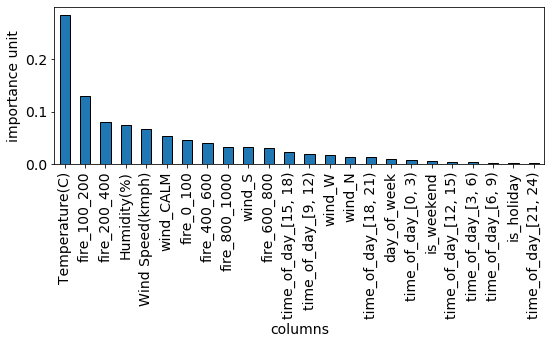

In [2]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='PM10', search_wind_damp=True)

In [4]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM10')

data no fire has shape (172233, 21)
raw model performance {'test_r2_score': 0.2869351053528041, 'test_mean_squared_error': 323.56606671093067, 'test_mean_absolute_error': 13.146837790609498}
daily avg training error {'avg_trn_r2_score': 0.7700699032786738, 'avg_trn_mean_squared_error': 77.42620950821473, 'avg_trn_mean_absolute_error': 6.589591997100774}
daily avg test error {'avg_test_r2_score': 0.3484523203658526, 'avg_test_mean_squared_error': 222.75280852747895, 'avg_test_mean_absolute_error': 10.908293292379689}


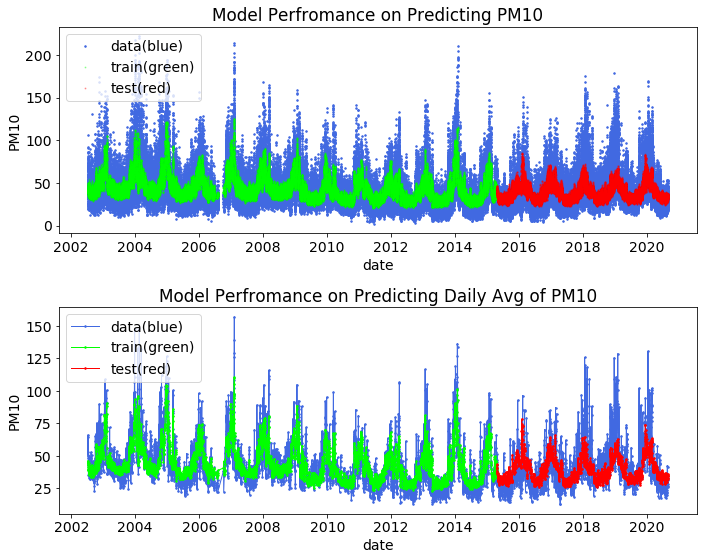

In [5]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## Train O3

data no fire has shape (172209, 21)
=================optimize 1: find the best RF model=================
xtrn has shape (62495, 26)
{'n_estimators': 160, 'min_samples_split': 50, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.6406739781088391
val score after op_rf {'val_r2_score': 0.5647507136800312, 'val_mean_squared_error': 106.28863783029428, 'val_mean_absolute_error': 6.856109525274524}
test score after op_rf {'test_r2_score': 0.5326093460650112, 'test_mean_squared_error': 128.25160273950436, 'test_mean_absolute_error': 7.727061154891887}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop is_rain
drop is_holiday
drop day_of_week
drop time_of_day_[3, 6)
drop time_of_day_[18, 21)
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 

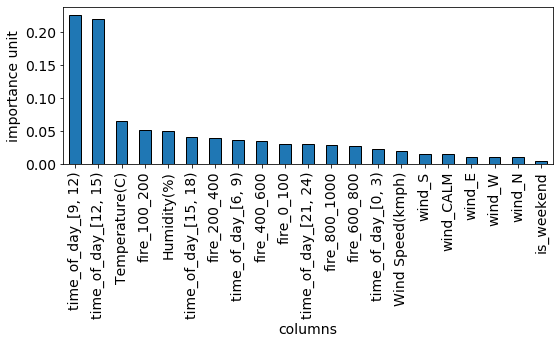

In [6]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='O3', search_wind_damp=True)

In [7]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='O3')

data no fire has shape (172230, 21)
raw model performance {'test_r2_score': 0.6112849635233042, 'test_mean_squared_error': 106.6595484657536, 'test_mean_absolute_error': 7.016516111004648}
daily avg training error {'avg_trn_r2_score': 0.8059246795575935, 'avg_trn_mean_squared_error': 9.941376710016245, 'avg_trn_mean_absolute_error': 2.3517200641314218}
daily avg test error {'avg_test_r2_score': 0.366585605251024, 'avg_test_mean_squared_error': 47.19135257986454, 'avg_test_mean_absolute_error': 4.945309198819954}


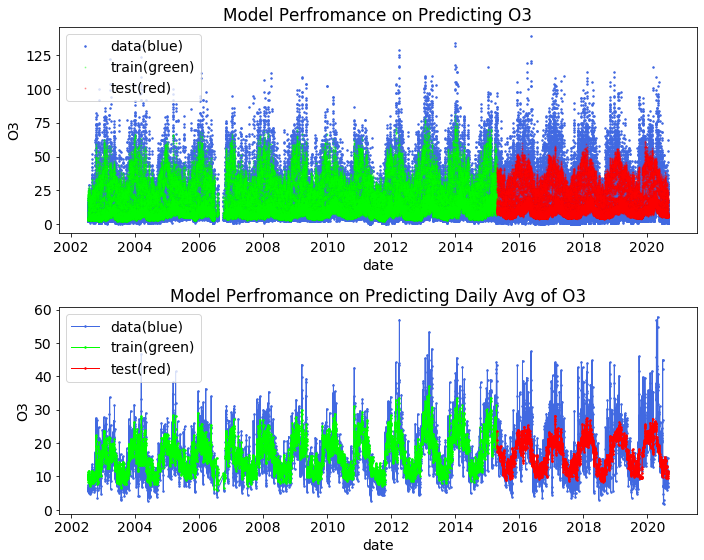

In [8]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## Train NO2

data no fire has shape (76368, 15)
=================optimize 1: find the best RF model=================
xtrn has shape (30355, 20)
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.24231452262225636
val score after op_rf {'val_r2_score': 0.2678307866209485, 'val_mean_squared_error': 111.33738490479391, 'val_mean_absolute_error': 8.114096684719359}
test score after op_rf {'test_r2_score': 0.37417382445746916, 'test_mean_squared_error': 91.7297848588591, 'test_mean_absolute_error': 7.388761190834165}
=================optimize 2: remove unncessary columns=================
old cols length 20
drop is_rain
drop is_weekend
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_holiday', 'day_of_week', 'time_of_day', 'traffic_index', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_600', 'fire_600_800', 'fire_800_1000']
score after dropp

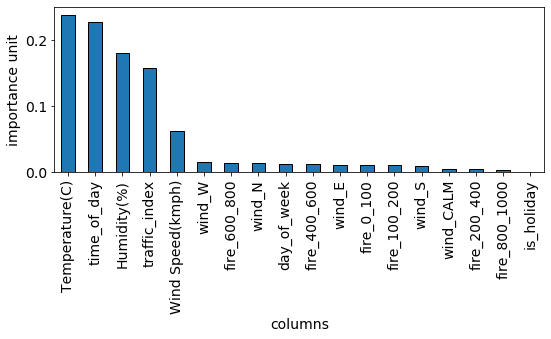

In [9]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='NO2', default_meta=True, search_wind_damp=True)

In [10]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='NO2')

data no fire has shape (76368, 15)
raw model performance {'test_r2_score': 0.39908662705065867, 'test_mean_squared_error': 89.46213051154928, 'test_mean_absolute_error': 7.021310198462453}
daily avg training error {'avg_trn_r2_score': 0.5881346922691971, 'avg_trn_mean_squared_error': 37.27518473918147, 'avg_trn_mean_absolute_error': 4.615326765673302}
daily avg test error {'avg_test_r2_score': 0.5211911799192189, 'avg_test_mean_squared_error': 46.23947648937689, 'avg_test_mean_absolute_error': 5.3850310969378805}


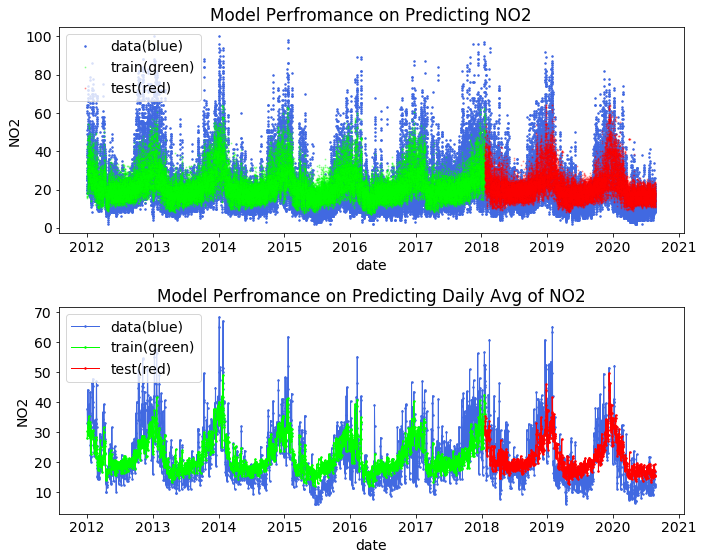

In [11]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

## TPOP PM10

In [ ]:
# implement the best parameters 
fire_col = fire_dict['fire_col']
w_speed = fire_dict['w_speed']
damp_surface = fire_dict['surface']
shift = fire_dict['shift']
roll = fire_dict['roll']
# obtain fire data 
fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
fire_col=fire_col,damp_surface=damp_surface, 
shift=shift, roll=roll, w_speed=w_speed)
 
# merge fire data 
data = data_no_fire.merge(fire_proc, left_index=True, right_index=True, how='inner')
data = data.dropna()
 
x_cols = ['Wind_Speed(kmph)', 'Temperature(C)', 'Humidity(%)', 'time_of_day',
       'fire_400_800', 'fire_800_1000', 'fire_200_400', 'fire_0_100',
       'fire_100_200', 'PM2.5_lag_1']
xtrn, ytrn, x_cols = get_data_matrix(data, pollutant,trn_idx, x_cols=x_cols)
xval, yval, _ = get_data_matrix(data, pollutant,val_idx, x_cols=x_cols)

In [ ]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(xtrn, ytrn)

In [ ]:
print(tpot.score(xval,yval))
tpot.export(dataset.model_folder+'PM10_tpot_pipeline.py')